In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")

In [2]:
NUM_SAMPLES: int = 1000
STATE: int = 2023
IN_FEATURES: int = 2
OUT_FEATURES: int = 3
CLASS_SEP = 1
TEMPLATE = "ggplot2"

In [88]:
import torch
from sklearn.datasets import make_moons, make_circles, make_classification
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


PALETTE = px.colors.qualitative.Plotly
figKwargs = dict(
    width=500,
    height=400,
)
showKwargs = dict(
    renderer="png", scale=2
)  # change renderer to "" to use interactive plots

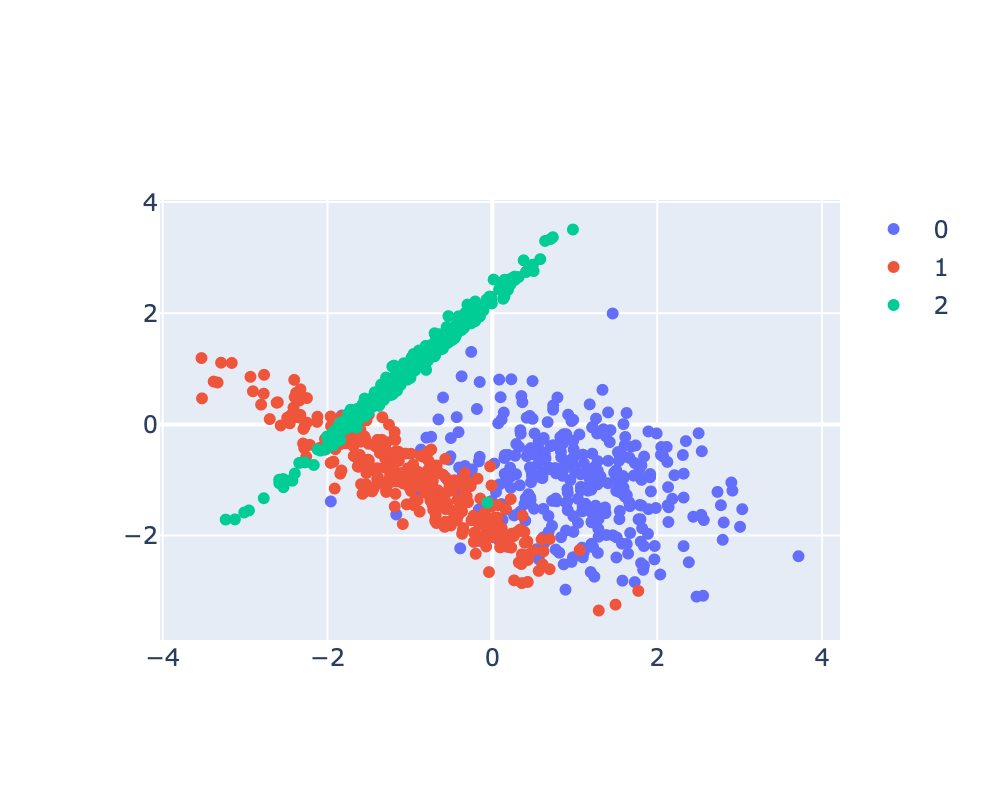

In [89]:
X, y = make_classification(
    n_samples=NUM_SAMPLES,
    n_features=IN_FEATURES,
    n_informative=IN_FEATURES,
    n_clusters_per_class=1,
    n_redundant=0,
    n_classes=OUT_FEATURES,
    class_sep=CLASS_SEP,
    random_state=STATE,
)
color = [PALETTE[int(i)] for i in y]
labels = {PALETTE[i]: i for i in range(OUT_FEATURES)}
labels["color"] = "label"
# X = (X - X.mean(0, keepdims=True)) / X.std(0, keepdims=True)
X = torch.from_numpy(X).to(torch.float32)
y = torch.from_numpy(y).to(torch.long)
fig = go.Figure(layout=figKwargs)
for cls in torch.unique(y):
    x = X[y == cls]
    y_ = cls.item()
    fig.add_trace(
        go.Scatter(
            x=x[:, 0], y=x[:, 1], mode="markers", name=f"{y_}", line_color=PALETTE[y_]
        )
    )
fig.show(**showKwargs)

In [105]:
from ml.losses.classification import CrossEntropyLoss
from ml.activations.functional import softmax
from ml.activations import ReLU, Sigmoid
from ml.models.linear import Linear
from ml.models.nn import Sequential
from ml.optim import SGD, Adam
from functools import partial

activation = partial(softmax, dim=1)

LR = 0.01
REG = 0.5
N = 3000
NUM_FEATS = 32

model_sgd = Sequential(
    [Linear(IN_FEATURES, NUM_FEATS), ReLU(), Linear(NUM_FEATS, OUT_FEATURES)],
    activation=activation,
)
optim = SGD(model_sgd.parameters(), model_sgd.grad(), LR, REG)
criterion = CrossEntropyLoss()

model_sgd.fit(X, y.to(torch.long), criterion, optim, N)

model_adam = Sequential(
    [Linear(IN_FEATURES, NUM_FEATS), ReLU(), Linear(NUM_FEATS, OUT_FEATURES)],
    activation=activation,
)
optim = Adam(model_adam.parameters(), model_adam.grad(), LR, REG)
criterion = CrossEntropyLoss()

model_adam.fit(X, y.to(torch.long), criterion, optim, N)

100%|██████████| 3000/3000 [00:03<00:00, 983.66it/s]


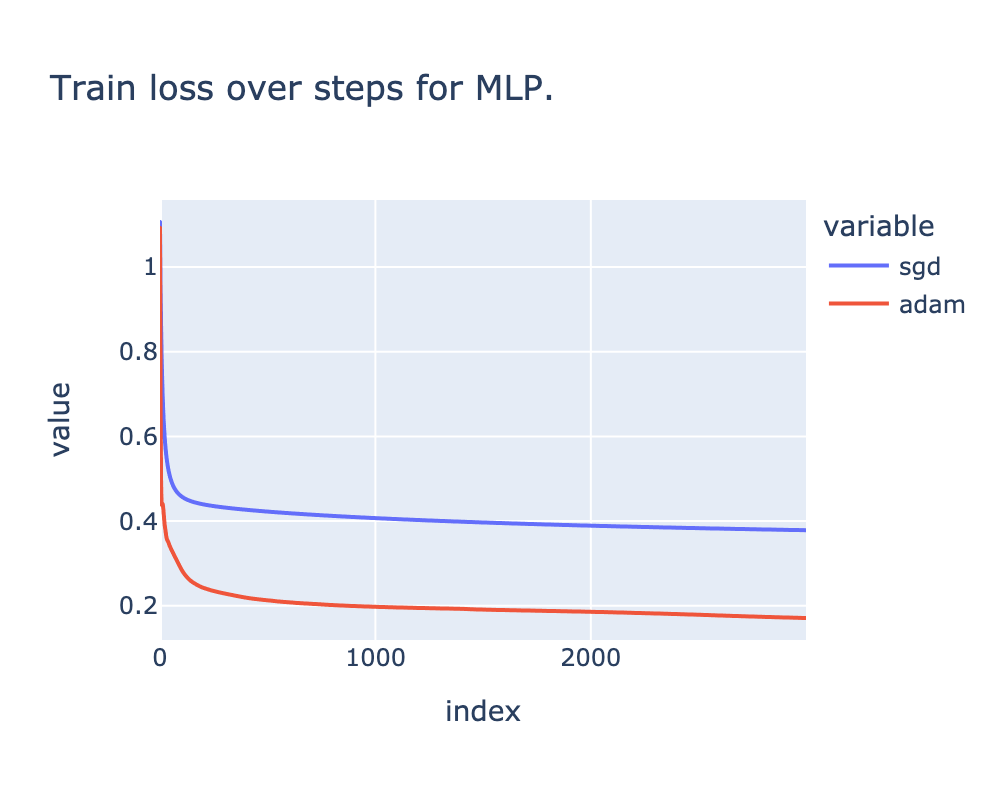

In [106]:
data = pd.DataFrame(dict(sgd=model_sgd.history, adam=model_adam.history))
fig = px.line(
    data,
    title="Train loss over steps for MLP.",
    **figKwargs,
)
fig.show(**showKwargs)

In [107]:
h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = torch.meshgrid(
    torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h), indexing="ij"
)
levels = torch.linspace(0, 1, 1000)
grid = torch.dstack([xx.ravel(), yy.ravel()])[0]

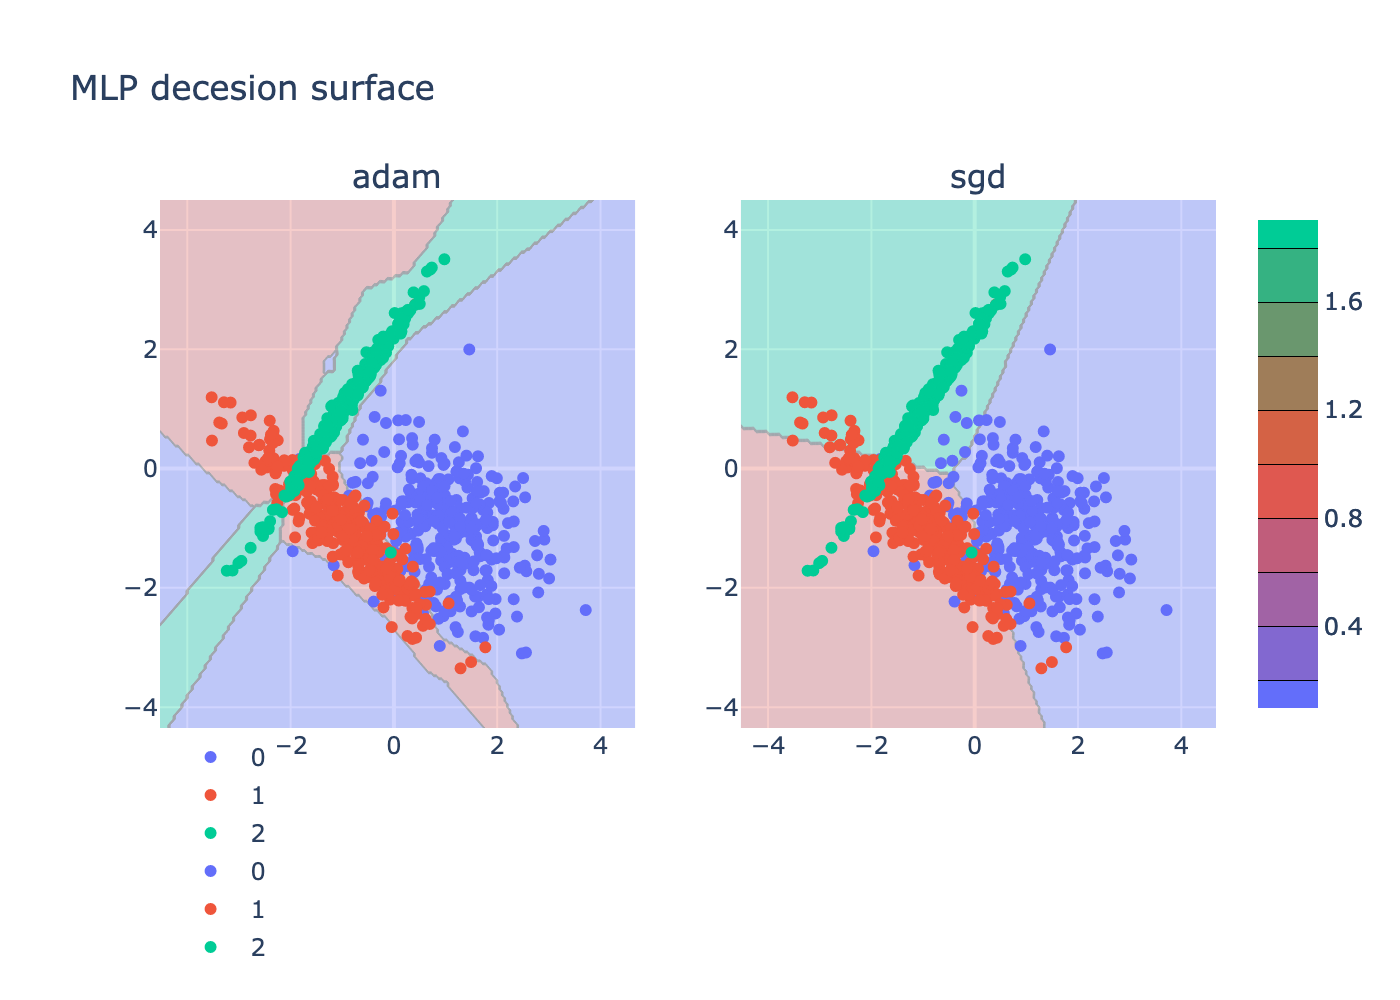

In [115]:
from plotly.subplots import make_subplots

models_dict = {"adam": model_adam, "sgd": model_sgd}
fig = make_subplots(1, len(models_dict), subplot_titles=tuple(models_dict.keys()))

for i, (name, model) in enumerate(models_dict.items()):
    gridOut = model.predict(grid).argmax(1, keepdim=True)
    fig.add_trace(
        go.Contour(
            x=xx[:, 0],
            y=yy[0],
            z=gridOut.reshape(xx.shape).T,
            opacity=0.3,
            line_smoothing=1.0,
            colorscale=PALETTE[:3],
        ),
        1,
        i + 1,
    )
    for cls in torch.unique(y):
        x = X[y == cls]
        y_ = int(cls.item())
        fig.add_trace(
            go.Scatter(
                x=x[:, 0],
                y=x[:, 1],
                mode="markers",
                name=f"{y_}",
                line_color=PALETTE[y_],
            ),
            1,
            i + 1,
        )
fig.update_layout(
    title="MLP decesion surface",
    legend=dict(yanchor="top", y=0.00, xanchor="left", x=0.01),
)
fig.show(**showKwargs)

In [113]:
from ml.metrics import get_stats, accuracy
import torch.nn.functional as F

for i, (name, model) in enumerate(models_dict.items()):
    output = model.predict(X)
    preds = output.argmax(1)
    stats = get_stats(F.one_hot(preds), F.one_hot(y))
    acc = accuracy(*stats).item()
    print(f"{name=}: {acc=:.3f}")

name='adam': acc=0.954
name='sgd': acc=0.906
